# 阿里云天池

## 二手车价格预测

* 版本2. 日期：2020年12月25日

### 0. 导入库

In [ ]:
# 基础库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 建模调参用的库
from sklearn.model_selection import GridSearchCV, cross_val_score  
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# 其他操作的库
# 去除warnings显示
import warnings
warnings.filterwarnings('ignore')
# 看大家都在用，我也不知道是干什么的，可能是直接作图用的吧
%matplotlib inline
# 处理时间
from datetime import datetime
# 取消最大列显示限制
pd.options.display.max_columns = None 

### 1. 导入数据

In [2]:
train = pd.read_csv('./input/used_car_train_20200313.csv', sep = ' ')
train.shape

(150000, 31)

In [3]:
testB_full = pd.read_csv('./input/used_car_testB_20200421.csv', sep=' ')
# 提交的时候需要用到testB的SaleID，但是SaleID在预测的时候是不用的，所以保存一份testB_full
testB = testB_full.drop(['SaleID'], axis=1)
testB.shape

(50000, 29)

### 2. 简单数据处理及分析

#### 2.1 查看数据内容

In [4]:
train.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,0,0,20160404,1850,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,-,4366,0,0,20160309,3600,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,0,0,20160402,6222,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,0,0,20160312,2400,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,0,0,20160313,5200,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [5]:
train.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.0,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,2583.077267,0.000007,0.0,2.016033e+07,5923.327333,44.406268,-0.044809,0.080765,0.078833,0.017875,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,1885.363218,0.002582,0.0,1.067328e+02,7501.998477,2.457548,3.641893,2.929618,2.026514,1.193661,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,2.015062e+07,11.000000,30.451976,-4.295589,-4.470671,-7.275037,-4.364565,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,1018.000000,0.000000,0.0,2.016031e+07,1300.000000,43.135799,-3.192349,-0.970671,-1.462580,-0.921191,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,2196.000000,0.000000,0.0,2.016032e+07,3250.000000,44.610266,-3.052671,-0.382947,0.099722,-0.075910,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,3843.000000,0.000000,0.0,2.016033e+07,7700.000000,46.004721,4.000670,0.241335,1.565838,0.868758,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,8120.000000,1.000000,0.0,2.016041e+07,99999.000000,52.304178,7.320308,19.035496,9.854702,6.829352,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [6]:
# 发现notRepairedDamage类型是object，后面需要转换成float64
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int64  
 1   name               150000 non-null  int64  
 2   regDate            150000 non-null  int64  
 3   model              149999 non-null  float64
 4   brand              150000 non-null  int64  
 5   bodyType           145494 non-null  float64
 6   fuelType           141320 non-null  float64
 7   gearbox            144019 non-null  float64
 8   power              150000 non-null  int64  
 9   kilometer          150000 non-null  float64
 10  notRepairedDamage  150000 non-null  object 
 11  regionCode         150000 non-null  int64  
 12  seller             150000 non-null  int64  
 13  offerType          150000 non-null  int64  
 14  creatDate          150000 non-null  int64  
 15  price              150000 non-null  int64  
 16  v_

#### 2.2 缺失值处理

In [7]:
# train缺失值查看
train.isnull().sum()[train.isnull().sum() > 0]

model          1
bodyType    4506
fuelType    8680
gearbox     5981
dtype: int64

In [8]:
# test 缺失值查看
testB.isnull().sum()[testB.isnull().sum() > 0]

bodyType    1504
fuelType    2924
gearbox     1968
dtype: int64

粗略一看可以看出train有model、bodyType、fuelType和gearbox这4个特征有缺失值，且model只有1个缺失值观测。
而testB则有bodyType、fuelType和gearbox这3个特征有缺失值。
接下来先处理model缺失值，剩下的在接下来的特征深入分析后来处理。

*model缺失值处理*

从别人处得到思路，相同车型model一般具有相同的brand、bodyType、gearbox、power和fuelType，我们在训练集中查找和缺失model观测上述5个特征一致的model作为缺失值的替换项。

In [9]:
# 查看model缺失值的观测
train[train['model'].isnull()]

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
38424,38424,148730,20150809,NaN,37,6.0,1.0,1.0,190,2.0,0.0,1425,0,0,20160320,47950,41.139365,-2.167089,-3.436008,-7.275037,6.829352,0.181562,0.002092,0.0,0.148487,0.222787,1.6757,-3.25056,0.876001,11.147669,8.658418


In [10]:
# 匹配brand是37、bodtType是6.0、gearbox是1.0、power是190且fuelTYpe是1.0的观测
train[(train['brand'] == 37) & 
      (train['bodyType'] == 6.0) & 
      (train['gearbox'] == 1.0) & 
      (train['power'] == 190) &
      (train['fuelType'] == 1.0)]['model'].value_counts()

157.0    17
199.0    16
202.0     8
200.0     1
Name: model, dtype: int64

In [11]:
# 157号model出现的次数最多，我们用157来替换
train.loc[38424, 'model'] = 157

#### 2.3 特征深入处理

按照个人的想法查看一些比较重要的特征，并且做图，可能会发现一些异常值或者离群点，值得关注的有以下特征：
* regDate：汽车注册日期
* creatDate：汽车开始出售时间
* model：车型
* brand：品牌
* bodyType：车身类型
* fuelType：燃油类型
* gearbox：变速箱
* power：发动机功率
* kilometer：汽车已行驶公里
* notRepairedDamage：是否有未修复的损坏
* regionCode：地区编码
* seller：销售方
* offerType：报价类型
* v0 - v14 ：15个匿名特征

##### 2.3.1 regDate和creatDate
单独看regDate可能并没有什么意义，但是和creatDate结合在一起可能就有意想不到的收获，汽车的开始出售时间减去汽车的注册时间就是我们买二手车最重要的考虑点：车龄。

一般情况下，新车前几年的二手车售价随着车龄的增加下降的明显，随后随着车龄的增加，二手车售价的降低会变慢。总体来说车龄和二手车售价呈负相关。

此外我们还需要注意一下是否存在开始出售时间比注册时间还要早的情况，这种情况表明某个观测存在一些错误，不可以被采用。

 regDate中的月份位有很多00这种错误的月份格式，可以用如下代码查看：
>train[(train['regDate']/100).astype('int64')%100 == 0]

发现有11347个观测有这种错误，这个数量相对于原始的15万观测不是一个小数据，我开始以为可能是1月的错误表示，但我发现这些错误的年份中仍然有12月出现，所以这些可能是某个系统错误。
 
解决的办法有两个，一个是直接删除，但是这样我们就损失了10%的训练数据；还有一个是给这些错误的月份加上6，指定为该年年中购买。


In [12]:
# 创建将regDate和creatDate转为时间的处理方法
def to_date(x):
    year = int(str(x)[:4])
    month = int(str(x)[4:6])
    day = int(str(x)[6:8])
    
    if month == 0:
        month = 6
        
    date = datetime(year, month, day)
    return date

In [13]:
# train转换regDate和creatDate
train['regDate'] = train['regDate'].apply(to_date)
train['creatDate'] = train['creatDate'].apply(to_date)

# 新建特征age
train['age'] = (train['creatDate'] - train['regDate']).dt.days

In [14]:
# 检查train是否有age为负数的情况，发现没有这类错误。
train[train['age'] < 0]

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,age


In [15]:
# testB转换regDate和creatDate
testB['regDate'] = testB['regDate'].apply(to_date)
testB['creatDate'] = testB['creatDate'].apply(to_date)

# 新建特征age
testB['age'] = (testB['creatDate'] - testB['regDate']).dt.days

In [16]:
# 检查testB是否有age为负数的情况，发现没有这类错误。
testB[testB['age'] < 0]

,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,age


Text(0.5, 1.0, 'Figure1: age distribution')

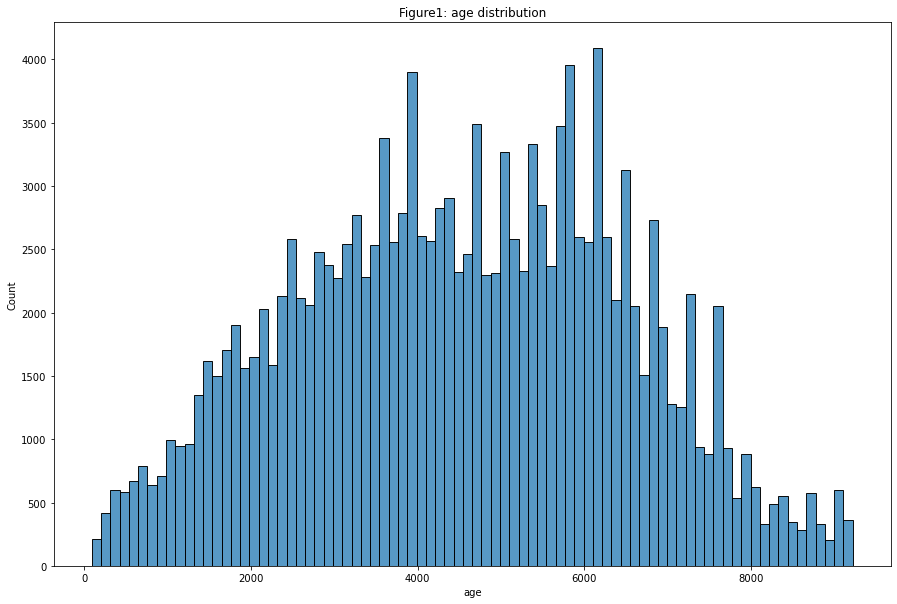

In [17]:
# 查看age的分布情况
plt.figure(figsize = (15,10))
sns.histplot(data = train, x = train['age']).set_title('Figure1: age distribution')

age的分布符合正态，无需处理。

##### 2.3.2 model
model。车型编码。

In [18]:
# 快速查看分布
train['model'].value_counts()

0.0      11762
19.0      9573
4.0       8445
1.0       6038
29.0      5186
         ...  
245.0        2
209.0        2
240.0        2
242.0        2
247.0        1
Name: model, Length: 248, dtype: int64

Text(0.5, 1.0, 'Figure2: model distribution')

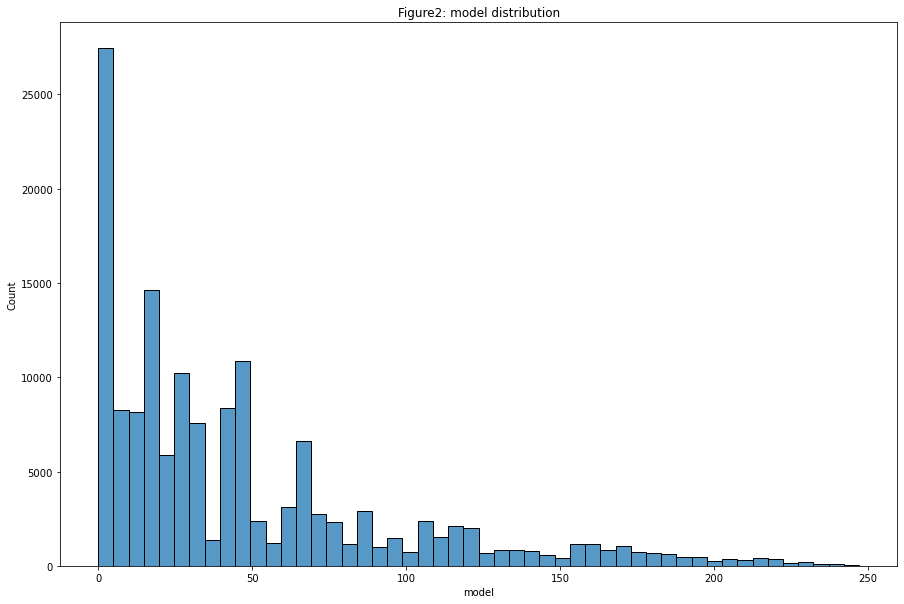

In [19]:
# 查看下特征model分布
plt.figure(figsize = (15,10))
sns.histplot(data = train, x = train['model'],bins = 50).set_title('Figure2: model distribution')

因为model特征已经被脱敏，所以我们看不出其他信息，只能通过直方图看出图形右偏，而且model数字小的车型会更加多一些。

##### 2.3.3 brand
汽车品牌

In [20]:
# 快速查看分布
train['brand'].value_counts()

0     31480
4     16737
14    16089
10    14249
1     13794
6     10217
9      7306
5      4665
13     3817
11     2945
3      2461
7      2361
16     2223
8      2077
25     2064
27     2053
21     1547
15     1458
19     1388
20     1236
12     1109
22     1085
26      966
30      940
17      913
24      772
28      649
32      592
29      406
37      333
2       321
31      318
18      316
36      228
34      227
33      218
23      186
35      180
38       65
39        9
Name: brand, dtype: int64

Text(0.5, 1.0, 'Figure3: brand distribution')

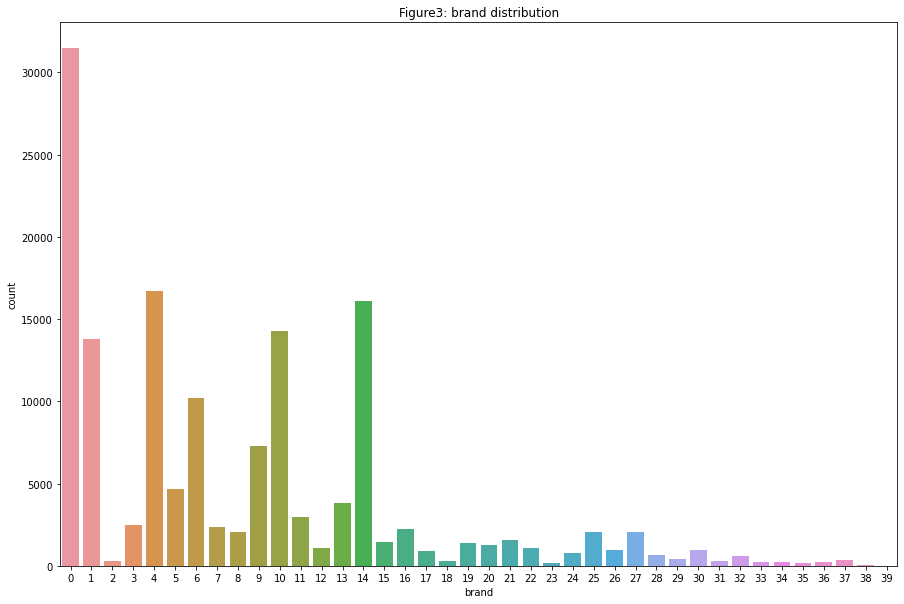

In [21]:
# 查看特征brand分布
plt.figure(figsize = (15,10))
sns.countplot(x = train['brand']).set_title('Figure3: brand distribution')

因为brand品牌已经被脱敏，所以只能从分布图上看出，品牌0，1，4，6，10和14比较多，其他品牌比较少。

##### 2.3.4 bodyType
车身类型
0. 豪华轿车
1. 微型车
2. 箱型车
3. 大巴车
4. 敞篷车
5. 双门汽车
6. 商务车
7. 搅拌车

In [22]:
# 快速查看分布
train['bodyType'].value_counts()

0.0    41420
1.0    35272
2.0    30324
3.0    13491
4.0     9609
5.0     7607
6.0     6482
7.0     1289
Name: bodyType, dtype: int64

Text(0.5, 1.0, 'Figure4: bodyType distribution')

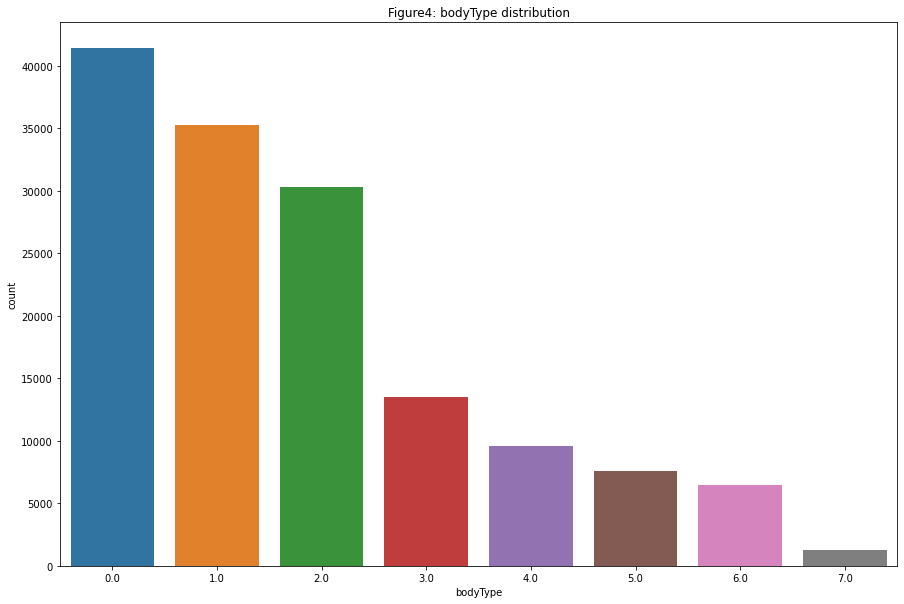

In [23]:
plt.figure(figsize = (15,10))
sns.countplot(x = train['bodyType']).set_title('Figure4: bodyType distribution')

通过上图可以看出，最主要的车辆类型是豪华轿车、微型车和箱型车，其他的车辆较少。

在2.2缺失值处理部分中我们发现bodyTYpe是有缺失值的，查看缺失值的数量。我们应用数量最多的豪华轿车0.0来替换缺失值。

In [24]:
# 替换缺失值
train.loc[:, 'bodyType'] = train['bodyType'].map(lambda x: 0.0 if pd.isnull(x) else x)
testB.loc[:, 'bodyType'] = testB['bodyType'].map(lambda x: 0.0 if pd.isnull(x) else x)

##### 2.3.5 fuelType
fuelType。燃油类型。
0. 汽油
1. 柴油
2. 液化石油气
3. 天然气
4. 混合动力
5. 其他
6. 电动

In [25]:
# 快速查看分布
train['fuelType'].value_counts()

0.0    91656
1.0    46991
2.0     2212
3.0      262
4.0      118
5.0       45
6.0       36
Name: fuelType, dtype: int64

Text(0.5, 1.0, 'Figure5: fuelType distribution')

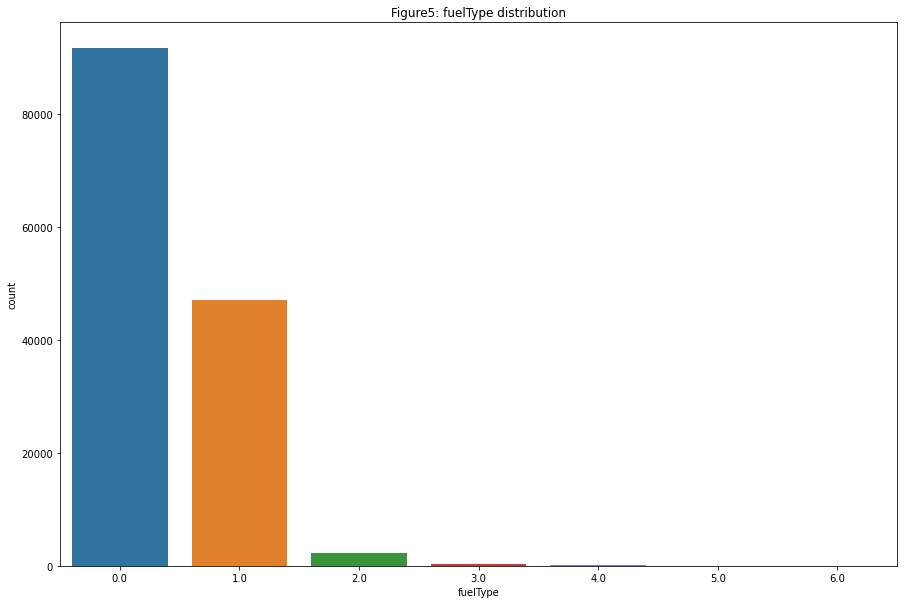

In [26]:
# 查看特征fuelType分布
plt.figure(figsize = (15,10))
sns.countplot(x = train['fuelType']).set_title('Figure5: fuelType distribution')

从上图中可以发现，最多的燃油类型是汽油和柴油，其他的燃油类型非常的少。分布很不均匀。

接下来处理fuelType的缺失值。

一般来说豪华轿车大多是汽油车，而搅拌车这种很多都是柴油车。所以燃油类型有缺失的值可以参考其相同类型车的燃油类型来做替换。
具体操作就是我们来求出每一类车fuelType的众数，然后填充给相应的bodyType的缺失值。

In [27]:
# 创建字典，保存不同bodyType下， fuelType的众数，并以此填充fuelTyp的缺失值
dict_bodyType_train, dict_bodyType_testB = {}, {}
for i in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]:
    dict_bodyType_train[i] = train[train['bodyType'] == i]['fuelType'].mode()[0]
    dict_bodyType_testB[i] = testB[testB['bodyType'] == i]['fuelType'].mode()[0]

In [28]:
dict_bodyType_train

{0.0: 0.0,
 1.0: 0.0,
 2.0: 1.0,
 3.0: 1.0,
 4.0: 0.0,
 5.0: 0.0,
 6.0: 1.0,
 7.0: 1.0}

In [29]:
dict_bodyType_testB

{0.0: 0.0,
 1.0: 0.0,
 2.0: 1.0,
 3.0: 1.0,
 4.0: 0.0,
 5.0: 0.0,
 6.0: 1.0,
 7.0: 1.0}

train和testB数据集的结果一致。

In [30]:
# 开始填充fuelType缺失值
# 在含fuelType缺失值的条目中，将不同bodyType对应的index输出保存到一个字典中
dict_index_train, dict_index_testB = {}, {}
# 分别保存不同bodyType缺失值的index
for bodytype in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]:
    dict_index_train[bodytype] = train[(train['bodyType'] == bodytype) & (train['fuelType'].isnull())].index.tolist()
    dict_index_testB[bodytype] = testB[(testB['bodyType'] == bodytype) & (testB['fuelType'].isnull())].index.tolist()

In [31]:
# 分别对每个bodyTYpe所对应的index来填充fuelType列
for bt, ft in dict_bodyType_train.items():
    train.loc[dict_index_train[bt], 'fuelType'] = ft  
    testB.loc[dict_index_testB[bt], 'fuelType'] = ft

##### 2.3.6 gearbox
gearbox。变速箱
变速箱主要有两种，分别是手动挡和自动挡。
0. 手动挡
1. 自动挡

In [32]:
# 快速查看分布
train['gearbox'].value_counts()

0.0    111623
1.0     32396
Name: gearbox, dtype: int64

Text(0.5, 1.0, 'Figure6: gearbox distribution')

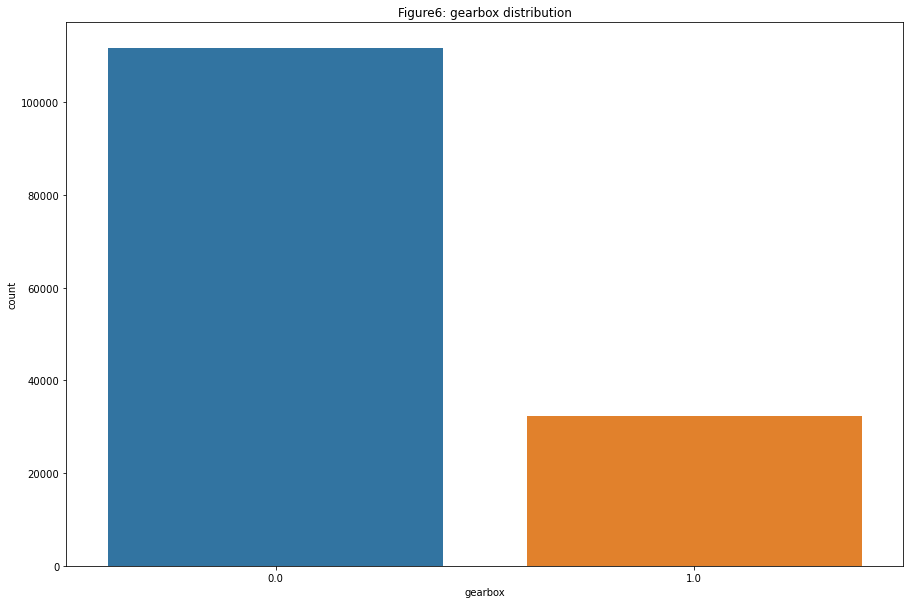

In [33]:
# 查看特征gearbox的分布
plt.figure(figsize = (15,10))
sns.countplot(x = train['gearbox']).set_title('Figure6: gearbox distribution')

由上图可以看出手动挡要比自动档要多很多。

接下来处理gearbox的缺失值。因为手动挡要多得多，所以直接以手动挡0.0替换缺失值。

In [34]:
# 都用0手动挡来替换缺失值
train.loc[:, 'gearbox'] = train['gearbox'].map(lambda x: 0.0 if pd.isnull(x) else x)
testB.loc[:, 'gearbox'] = testB['gearbox'].map(lambda x: 0.0 if pd.isnull(x) else x)

##### 2.3.7 power
power。发动机功率，马力。一般来说越大越好,马力和价格呈正相关。

In [35]:
# 首先查看下power的分布
train['power'].describe()

count    150000.000000
mean        119.316547
std         177.168419
min           0.000000
25%          75.000000
50%         110.000000
75%         150.000000
max       19312.000000
Name: power, dtype: float64

在power的统计信息中，我们发现两个问题。
1. power的最大值为19312，这个数值远远超过了给定的power范围（0到600），这些值应该是因为输入错误所导致的异常值，我们统计一下power超过600的观测，并且将其指定为600。
2. power的最小值为0，很显然，不可能存在power为0的汽车，这个0可能是输入错误导致，也可能是因为是一个缺失值而用0来代替，不管如何，我们需要统计一下power为0的观测，将其替换为np.nan。并且大胆做一个推断，相同model的汽车的power差不多，所以将不同的model的汽车的power均值替换相应的model的power缺失值。

In [36]:
# power大于600的处理，直接指定为600
train['power'] = train['power'].map(lambda x: 600 if x > 600 else x)
testB['power'] = testB['power'].map(lambda x:600 if x > 600 else x)

In [37]:
#将power为0替换成np.nan
train['power'] = train['power'].replace(0, np.nan)

# 查看power缺失值情况
train['power'].isnull().value_counts()

False    137171
True      12829
Name: power, dtype: int64

In [38]:
# 创建字典，保存不同model下， power的平均数，并以此填充相应model的缺失值
dict_model_train, dict_model_testB = {}, {}
model_loop = train['model'].unique().tolist()
for i in model_loop:
    dict_model_train[i] = train[train['model'] == i]['power'].mean()
    dict_model_testB[i] = testB[testB['model'] == i]['power'].mean()

In [39]:
dict_model_train

{30.0: 72.64046021093002,
 40.0: 150.55769230769232,
 115.0: 141.14966740576497,
 109.0: 278.65,
 110.0: 62.98580121703854,
 24.0: 123.1145038167939,
 13.0: 197.13536142897013,
 26.0: 107.02549781447304,
 19.0: 143.85607541096678,
 7.0: 111.70965309200604,
 1.0: 132.81499556344278,
 48.0: 68.11267605633803,
 65.0: 132.3484251968504,
 138.0: 144.4140127388535,
 105.0: 210.30068337129842,
 114.0: 153.84732824427482,
 0.0: 109.16710586097228,
 8.0: 134.85664854176966,
 78.0: 133.18533604887983,
 21.0: 61.57670126874279,
 3.0: 79.7467911318553,
 4.0: 157.70267554327347,
 31.0: 156.6352773826458,
 121.0: 190.83833116036507,
 75.0: 222.78389830508473,
 17.0: 187.49602213766863,
 107.0: 80.37440758293839,
 16.0: 68.77067348678602,
 111.0: 139.65891472868216,
 47.0: 205.62166962699823,
 5.0: 94.1651282051282,
 44.0: 117.57478005865103,
 200.0: 128.73170731707316,
 155.0: 120.42729306487696,
 87.0: 131.2746170678337,
 20.0: 91.20157068062828,
 22.0: 76.08352144469526,
 63.0: 127.21004566210046,

In [40]:
dict_model_testB

{30.0: 65.31021437578815,
 40.0: 142.11023622047244,
 115.0: 137.7015873015873,
 109.0: 246.79508196721312,
 110.0: 58.32960893854749,
 24.0: 118.44262295081967,
 13.0: 186.78995057660626,
 26.0: 97.7691798941799,
 19.0: 131.4807811531308,
 7.0: 102.51809954751131,
 1.0: 97.9979808177688,
 48.0: 59.71011104617183,
 65.0: 122.40958605664488,
 138.0: 132.45098039215685,
 105.0: 209.14457831325302,
 114.0: 154.79245283018867,
 0.0: 101.72534464475079,
 8.0: 123.59357923497268,
 78.0: 123.39428571428572,
 21.0: 55.232484076433124,
 3.0: 74.84053156146179,
 4.0: 146.73189964157706,
 31.0: 145.75565964090555,
 121.0: 181.96370967741936,
 75.0: 211.42285714285714,
 17.0: 174.2913843175218,
 107.0: 71.28,
 16.0: 60.183794466403164,
 111.0: 129.30985915492957,
 47.0: 200.98048780487804,
 5.0: 89.98522895125554,
 44.0: 110.16689466484269,
 200.0: 120.75675675675676,
 155.0: 114.22222222222223,
 87.0: 122.75617283950618,
 20.0: 87.90350877192982,
 22.0: 66.88796680497926,
 63.0: 115.2135922330097

In [41]:
# 开始填充power缺失值
# 在含power缺失值的条目中，将不同model对应的index输出保存到一个字典中
dict_index_train, dict_index_testB = {}, {}
# 分别保存不同bodyType缺失值的index
for model in model_loop:
    dict_index_train[model] = train[(train['model'] == model) & (train['power'].isnull())].index.tolist()
    dict_index_testB[model] = testB[(testB['model'] == model) & (testB['power'].isnull())].index.tolist()

In [42]:
# 分别对每个model所对应的index来填充power列
for model, power in dict_model_train.items():
    train.loc[dict_index_train[model], 'power'] = power
    testB.loc[dict_index_testB[model], 'power'] = power

In [43]:
# 检查是否替换成功
train['power'].isnull().value_counts()

False    150000
Name: power, dtype: int64

In [44]:
# 检查是否替换成功
testB['power'].isnull().value_counts()

False    50000
Name: power, dtype: int64

Text(0.5, 1.0, 'Figure7: power distribution')

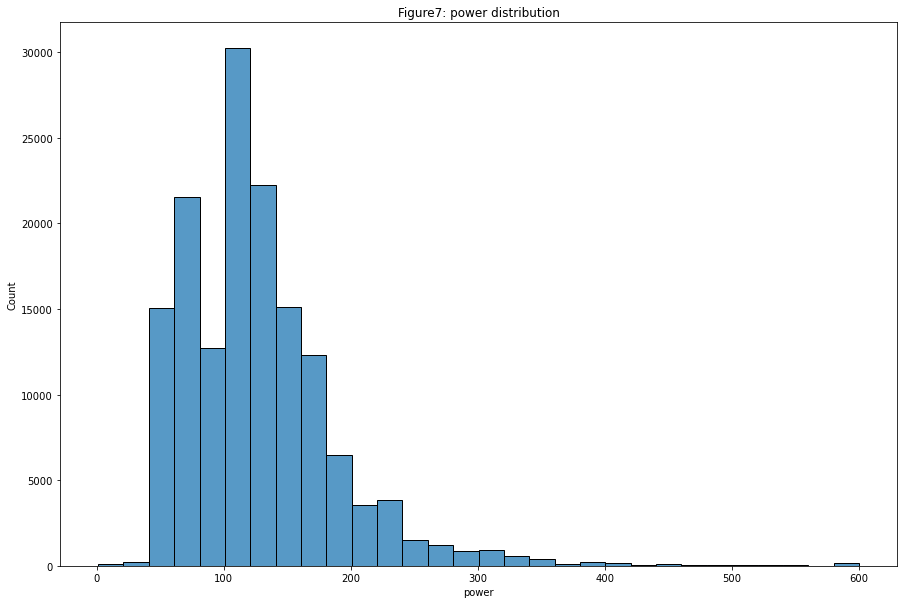

In [45]:
# 查看特征power分布
plt.figure(figsize = (15,10))
sns.histplot(data = train, x = train['power'],bins = 30).set_title('Figure7: power distribution')

由上图可以看出绝大部分的车的power都在100左右，并且右偏。这里可能需要做一个分箱，这次就不分了，下次一定。

##### 2.3.8 kilometer
kilometer。汽车已行驶里程数，单位公里。一般来说二手汽车里程数和售价呈负相关。

In [46]:
train['kilometer'].describe()

count    150000.000000
mean         12.597160
std           3.919576
min           0.500000
25%          12.500000
50%          15.000000
75%          15.000000
max          15.000000
Name: kilometer, dtype: float64

Text(0.5, 1.0, 'Figure8: kilometer distribution')

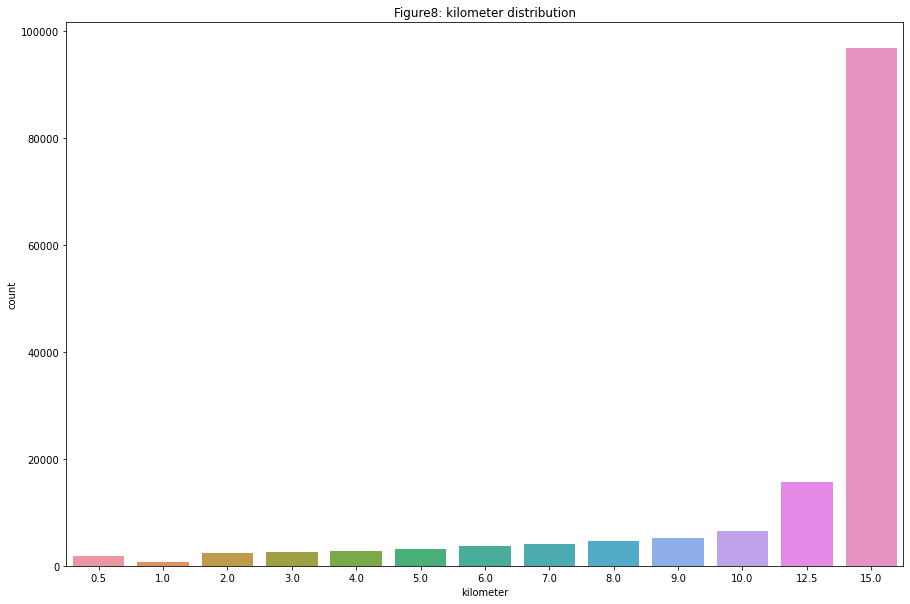

In [47]:
# 查看特征kilometer分布
plt.figure(figsize = (15,10))
sns.countplot(x = train['kilometer']).set_title('Figure8: kilometer distribution')

上图显示，已行驶里程数大多数都是15，并且远远大于12.5，猜测可能是超过15之后做了一个截断，这里也许可以做一个分箱。

##### 2.3.9 notRepairedDamage
notRepairedDamage。是否有未修复的损坏。
0. 是
1. 否

In [48]:
# 查快速查看分布
train['notRepairedDamage'].value_counts()

0.0    111361
-       24324
1.0     14315
Name: notRepairedDamage, dtype: int64

首先现将'-'替换成np.nan，此外该特征的类型是object，需要转换成数值类型。对于缺失值处理我们用最多的0.0来替换缺失值。

In [49]:
# 转换'-'
train['notRepairedDamage'] = train['notRepairedDamage'].replace('-', np.nan) 
testB['notRepairedDamage'] = testB['notRepairedDamage'].replace('-', np.nan)

# 转换数据类型
train['notRepairedDamage'] = train['notRepairedDamage'].astype('float64')
testB['notRepairedDamage'] = testB['notRepairedDamage'].astype('float64')

In [50]:
# 使用0.0替换缺失值
train.loc[:, 'notRepairedDamage'] = train['notRepairedDamage'].map(lambda x: 0.0 if pd.isnull(x) else x)
testB.loc[:, 'notRepairedDamage'] = testB['notRepairedDamage'].map(lambda x: 0.0 if pd.isnull(x) else x)

Text(0.5, 1.0, 'Figure9: notRepairedDamage distribution')

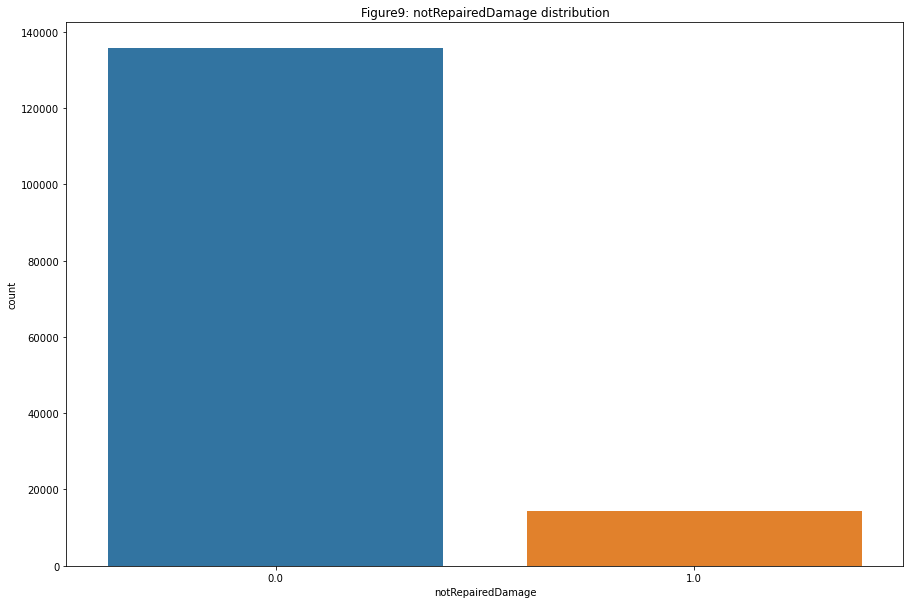

In [51]:
# 查看特征notRepairedDamage的分布
plt.figure(figsize = (15,10))
sns.countplot(x = train['notRepairedDamage']).set_title('Figure9: notRepairedDamage distribution')

##### 2.3.10 regionCode
regionCode。地区代码，已脱敏。

看论坛发现了一个技巧，区域代号去除后面三位就是城市代号，我们也这么做。

In [52]:
# 去掉regionCode后三位的结果就是city代号
train['city'] = train['regionCode'].apply(lambda x: str(x)[:-3])
testB['city'] = testB['regionCode'].apply(lambda x: str(x)[:-3])

In [53]:
# 查看此时city的类型,发现是object。
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 33 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   SaleID             150000 non-null  int64         
 1   name               150000 non-null  int64         
 2   regDate            150000 non-null  datetime64[ns]
 3   model              150000 non-null  float64       
 4   brand              150000 non-null  int64         
 5   bodyType           150000 non-null  float64       
 6   fuelType           150000 non-null  float64       
 7   gearbox            150000 non-null  float64       
 8   power              150000 non-null  float64       
 9   kilometer          150000 non-null  float64       
 10  notRepairedDamage  150000 non-null  float64       
 11  regionCode         150000 non-null  int64         
 12  seller             150000 non-null  int64         
 13  offerType          150000 non-null  int64   

In [54]:
# 查看下city的分布情况
train['city'].value_counts()

     36680
1    31886
2    26481
3    20545
4    14969
5    10047
6     6304
7     2986
8      102
Name: city, dtype: int64

In [55]:
testB['city'].value_counts()

     12399
1    10411
2     8915
3     6791
4     4947
5     3413
6     2081
7     1012
8       31
Name: city, dtype: int64

发现train和testB的city都有一个''的分类。将其转换成0。此外需要将object格式转换成float64.

In [56]:
# 将''替换成0
train['city'] = train['city'].replace('', 0) 
testB['city'] = testB['city'].replace('', 0) 

# 再将格式转换成float64
train['city'] = train['city'].astype('float64')
testB['city'] = testB['city'].astype('float64')

##### 2.3.11 seller
seller。销售方。分为个体或者非个体，应该就是我们说的个人车主和二手车销售平台。
0. 个体
1. 非个体

In [57]:
# 快速查看seller分布
train['seller'].value_counts()

0    149999
1         1
Name: seller, dtype: int64

没有什么意义，这个特征可以删除。

##### 2.3.12 offerType
offerType。报价类型。
0. 提供
1. 请求

In [58]:
# 快速查看特征分布
train['offerType'].value_counts()

0    150000
Name: offerType, dtype: int64

这个特征也可以直接删除。

##### 2.3.13 v0到v14
15个匿名特征，无法从现实中考虑其意义，所以在特征工程中进行相关系数的分析，选择有意义的特征进行研究。

##### 2.3.14 price
price。二手车价格，是我们需要预测的数据。

Text(0.5, 1.0, 'Figure10 price distribution')

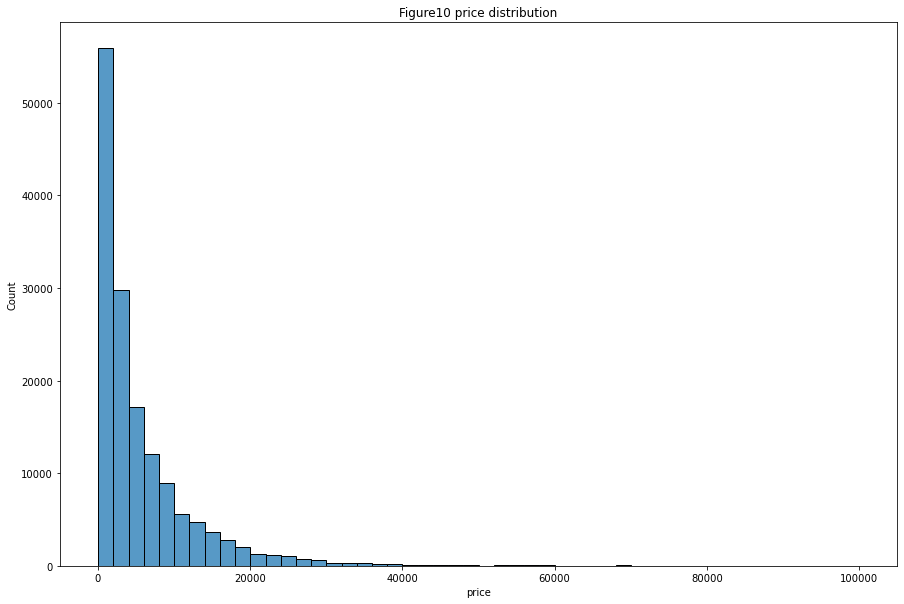

In [59]:
# 查看price的分布
plt.figure(figsize = (15,10))
sns.histplot(x = train['price'], bins = 50).set_title('Figure10 price distribution')

由上图可以看出价格右偏十分的严重。后期需要对其取log。

### 3. 特征工程
在本部分，我们将首先判断各个特征和与测量price的相关系数，然后删除掉一些特征，然后再对需要的特征做一些优化。

#### 3.1 特征筛选

In [60]:
# 查看各个特征和price的相关系数
train.corr().unstack()['price'].sort_values(ascending = False)

price                1.000000
v_12                 0.692823
v_8                  0.685798
v_0                  0.628397
power                0.576837
gearbox              0.330353
bodyType             0.248609
fuelType             0.200917
v_5                  0.164317
model                0.137049
v_2                  0.085322
v_6                  0.068970
v_1                  0.060914
v_14                 0.035911
city                 0.014176
regionCode           0.014036
name                 0.002030
SaleID              -0.001043
seller              -0.002004
v_13                -0.013993
brand               -0.043799
v_7                 -0.053024
v_4                 -0.147085
notRepairedDamage   -0.157523
v_9                 -0.206205
v_10                -0.246175
v_11                -0.275320
kilometer           -0.440519
age                 -0.611528
v_3                 -0.730946
offerType                 NaN
dtype: float64

特征的筛选按照如下的顺序：

* 相关系数很低的直接删除。我们删除绝对值低于0.2的特征。
* 在绝对值低于0.2的特征中，匿名特征直接删除，剩下的具有实际意义的特征需要考虑一下是保留还是删除。
* 一些特征已经创建了新的特征，其本身可以被删除了,例如regDate,creatDate,regionCode

根据筛选我们删除v_5,v_2,v_6,v_1,v_14,v_13,v_7,v_4,regionCode,name,SaleID,seller,offerType,regDate,creatDate.

In [61]:
# 删除特征
train.drop(['v_5','v_2', 'v_6', 'v_1', 'v_14', 'v_13', 'v_7','v_4','regionCode', 'name','SaleID','seller','offerType','regDate', 'creatDate'], axis=1, inplace=True)
testB.drop(['v_5','v_2', 'v_6', 'v_1', 'v_14', 'v_13', 'v_7','v_4','regionCode', 'name','seller','offerType','regDate', 'creatDate'], axis=1, inplace=True)

In [62]:
train.shape, testB.shape

((150000, 18), (50000, 17))

In [63]:
# 最后大概看下有没有什么问题
train.head(10)

,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,price,v_0,v_3,v_8,v_9,v_10,v_11,v_12,age,city
0,30.0,6,1.0,0.0,0.0,60.000000,12.5,0.0,1850,43.357796,2.159744,0.022816,0.097462,-2.881803,2.804097,-2.420821,4385,1.0
1,40.0,1,2.0,0.0,0.0,150.557692,15.0,0.0,3600,45.305273,1.380657,0.026597,0.020582,-4.900482,2.096338,-1.030483,4757,4.0
2,115.0,15,1.0,0.0,0.0,163.000000,12.5,0.0,6222,45.978359,-0.998467,0.062173,0.027075,-4.846749,1.803559,1.565330,4382,2.0
3,109.0,10,0.0,0.0,1.0,193.000000,15.0,0.0,2400,45.687478,0.883600,0.033395,0.000000,-4.509599,1.285940,-0.501868,7125,0.0
4,110.0,5,1.0,0.0,0.0,68.000000,5.0,0.0,5200,44.383511,-1.571239,0.078819,0.121534,-1.896240,0.910783,0.931110,1531,6.0
5,24.0,10,0.0,1.0,0.0,109.000000,10.0,0.0,8000,46.323165,-1.727217,0.090922,0.048769,1.885526,-2.721943,2.457660,2482,3.0
6,13.0,4,0.0,0.0,1.0,150.000000,15.0,0.0,3500,46.104335,1.644606,0.025446,0.028174,-4.902200,1.610616,-0.834605,6185,3.0
7,26.0,14,1.0,0.0,0.0,101.000000,15.0,0.0,1000,42.255586,1.942673,0.039839,0.082413,3.693829,-0.245014,-2.192810,6108,4.0
8,19.0,1,2.0,1.0,1.0,179.000000,15.0,0.0,2850,46.084888,0.556575,0.039851,0.024388,-4.925234,1.587796,0.075348,4798,4.0
9,7.0,7,5.0,0.0,0.0,88.000000,15.0,0.0,650,43.074626,3.096861,0.010291,0.098727,-1.089584,0.600683,-4.186210,6666,0.0


#### 3.1 匿名特征
匿名特征经过筛选后还剩下v_0, v_3, v_8, v_9, v_10, v_11, v_12需要考虑。

Text(0.5, 1.0, 'Figure11: v_0 distribution')

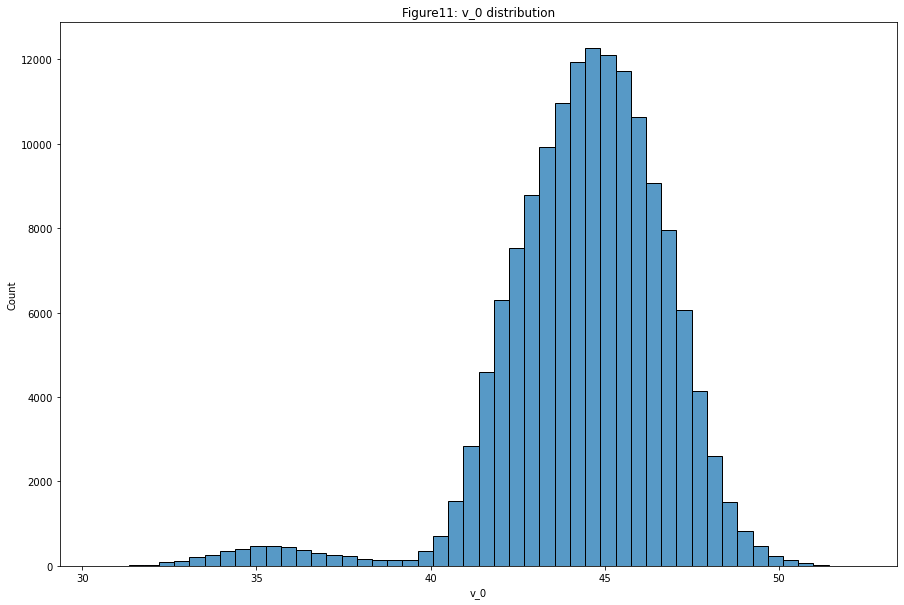

In [64]:
# v_0
plt.figure(figsize = (15,10))
sns.histplot(x = train['v_0'], bins = 50).set_title('Figure11: v_0 distribution')

v_0的分布比较接近正态，稍有左偏，无需进一步处理。

Text(0.5, 1.0, 'Figure12: v_3 distribution')

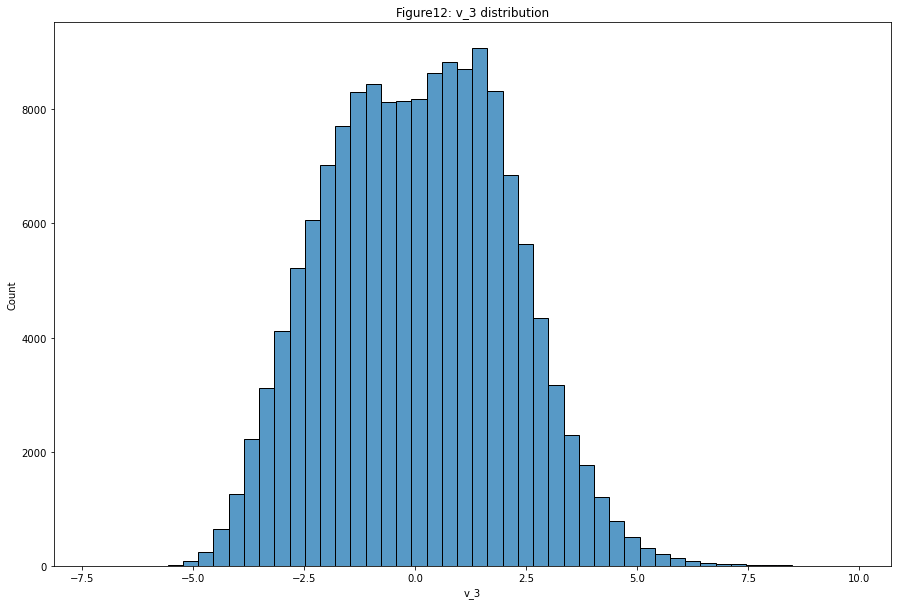

In [65]:
# v_3
plt.figure(figsize = (15,10))
sns.histplot(x = train['v_3'], bins = 50).set_title('Figure12: v_3 distribution')

v_3的分布接近正态，无需处理。

Text(0.5, 1.0, 'Figure13: v_8 distribution')

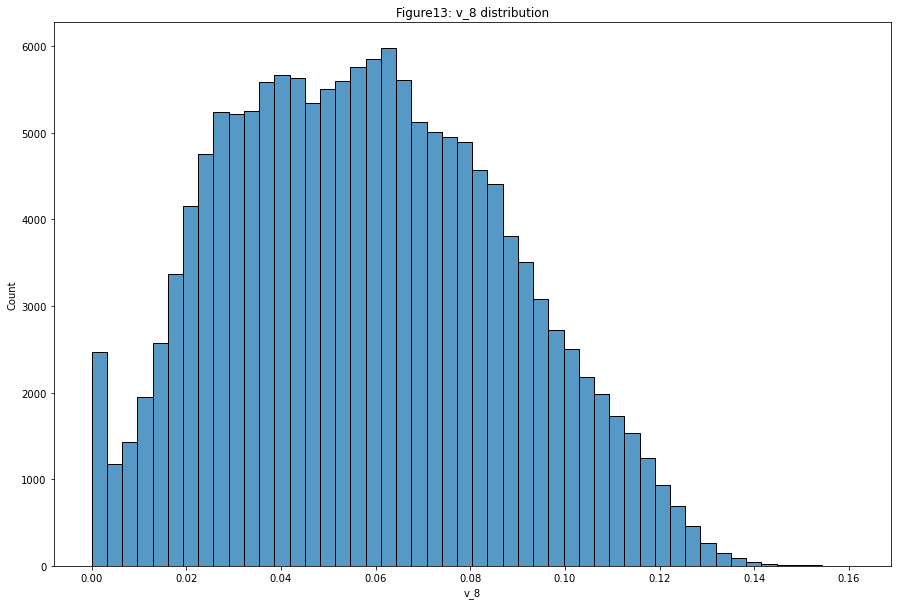

In [66]:
# v_8
plt.figure(figsize = (15,10))
sns.histplot(x = train['v_8'], bins = 50).set_title('Figure13: v_8 distribution')

由上图可以看出v_8的分布基本满足正态化，不需要进行处理。

Text(0.5, 1.0, 'Figure14: v_10 distribution')

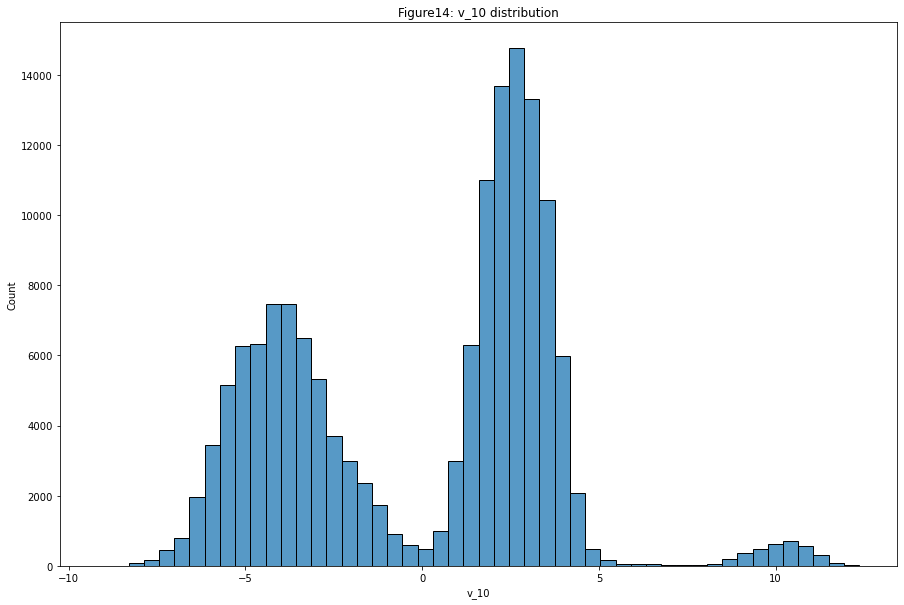

In [67]:
# v_10
plt.figure(figsize = (15,10))
sns.histplot(x = train['v_10'], bins = 50).set_title('Figure14: v_10 distribution')

由上图可以看出v_11的分布有三个峰，且每一个部分都接近正态，不做处理。

Text(0.5, 1.0, 'Figure15: v_11 distribution')

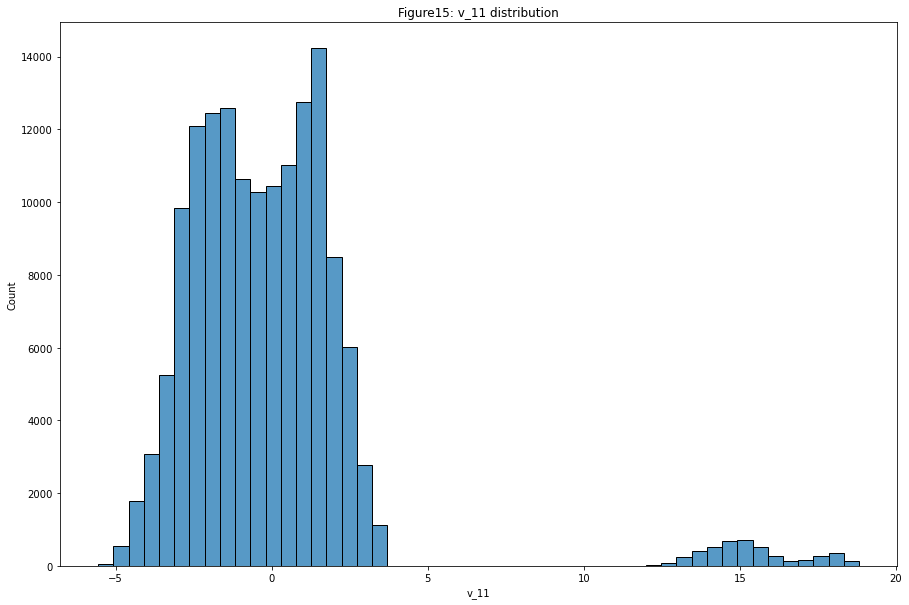

In [69]:
# v_11
plt.figure(figsize = (15,10))
sns.histplot(x = train['v_11'], bins = 50).set_title('Figure15: v_11 distribution')

v_11也是接近正态，但右侧在15处的有较多聚集。不作处理。

Text(0.5, 1.0, 'Figure16: v_12 distribution')

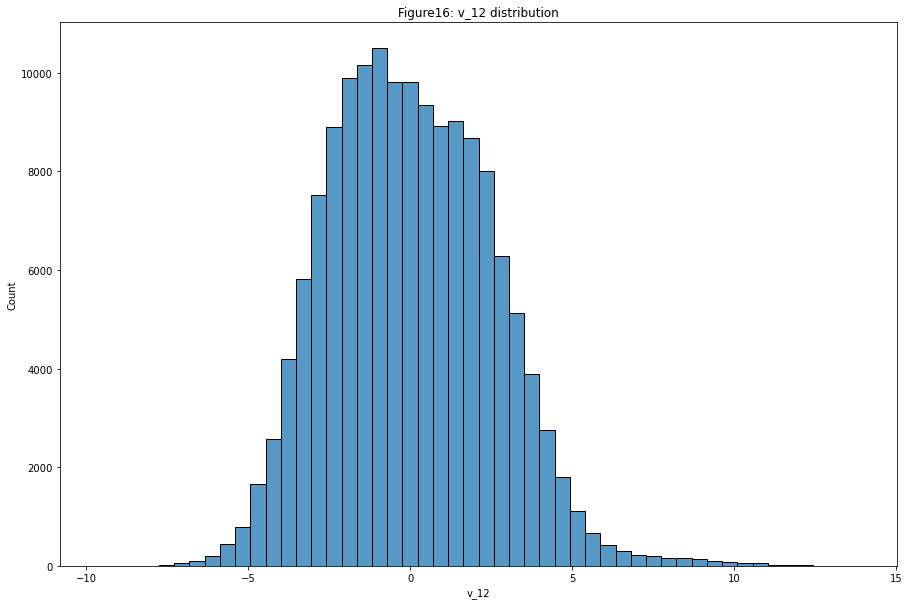

In [70]:
# v_12
plt.figure(figsize = (15,10))
sns.histplot(x = train['v_12'], bins = 50).set_title('Figure16: v_12 distribution')

v_12结果近似正态，不需要处理。

#### 3.3 数据集划分

In [71]:
train_price = train['price']
train = train.drop(['price'],axis = 1)

### 4 模型预测

### 4.1 建模
首先选择三个模型：随机森林、XGBoost、GBDT梯度提升树

In [72]:
# 三个模型
rf = RandomForestRegressor(n_estimators = 100, max_depth = 10, random_state = 1)
xgb = XGBRegressor(n_estimators = 100, max_depth = 10, learning_rate = 0.1, random_state = 1)
gbdt = GradientBoostingRegressor(subsample = 1, random_state = 1)

x = train
y = train_price

In [73]:
# 交叉验证
score_rf = -1 * cross_val_score(rf, x, y, scoring = 'neg_mean_absolute_error', cv = 5,n_jobs = -1).mean()
print('随机森林模型的平均MAE为： ', score_rf)

# XGBoost
score_xgb = -1 * cross_val_score(xgb, x, y, scoring = 'neg_mean_absolute_error', cv = 5,n_jobs = -1).mean()
print('XGBoost模型的平均MAE为： ', score_xgb)

# GBDT梯度提升树
score_gbdt = -1 * cross_val_score(gbdt, x, y, scoring = 'neg_mean_absolute_error', cv = 5,n_jobs = -1).mean()
print('GBDT梯度提升树模型的平均MAE为：', score_gbdt)

随机森林模型的平均MAE为：  802.0137468807492
XGBoost模型的平均MAE为：  580.2789127514561
GBDT梯度提升树模型的平均MAE为： 884.4403094095389


发现效果最好的XGBoost是，使用网格搜索调参。

下面的几个参数是我试了很多次使出来的比较适合的,

* n_estimators:大点会更加好，但也不是越大越好，我试过50,100,150,250,500,750,1000 发现1000最好，后面就没有试了。

* learning_rate：学习率太大太小都不好，我试了0.01, 0.04, 0.05,0.06,0.1,0.5,1 发现大概0.05最好。

* subsample：采样率，小于1可以降低方差，但是会增加偏差，我试了0.5,0.8,1.0,1.2 发现0.8最好。

* max_depth：树枝的最大深度，我设置了5，10，15，20 发现10最好。

In [75]:
# 交叉验证
# 注意，如果不想电脑全速运行的话，可以删掉n_jobs = -1，或者将-1改成你想调用的cpu线程数。
params = {
    'n_estimators': [50,100,1000],
    'learning_rate': [0.05],
    'subsample': [0.8],
    'max_depth':[10]
}

model = GridSearchCV(estimator = xgb,
                    param_grid = params,
                    scoring = 'neg_mean_absolute_error',
                    cv = 3,
                     n_jobs = -1,
                     verbose=10
                    )

model.fit(x, y)

# 输出最佳参数
print('最佳参数为：\n', model.best_params_)
print('最佳分数为：\n', model.best_score_)
print('最佳模型为：\n', model.best_estimator_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   24.6s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   24.7s remaining:   49.3s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   48.7s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   48.9s remaining:   39.1s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   48.9s remaining:   24.5s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  6.7min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  6.7min finished


[10:18:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
最佳参数为：
 {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.8}
最佳分数为：
 -538.7542993950666
最佳模型为：
 XGBRegressor(learning_rate=0.05, max_depth=10, n_estimators=1000,
             random_state=1, subsample=0.8)


### 5 提交结果

In [259]:
# 提交结果
predictions = model.predict(testB)
result = pd.DataFrame({'SaleID':testB_full['SaleID'], 'price':predictions})
result.to_csv('./output/result_20201225_2.csv', index = False)